In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Paths (for Google Colab)
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (54808, 14)
Test shape: (23490, 13)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


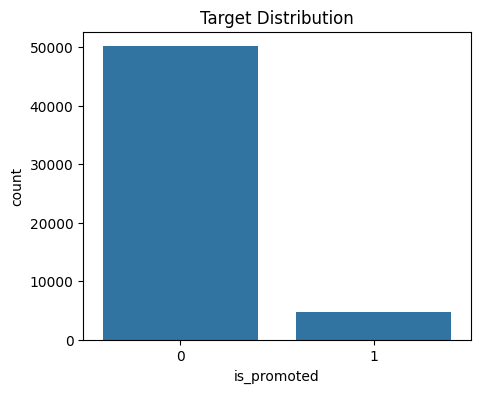

        employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min    

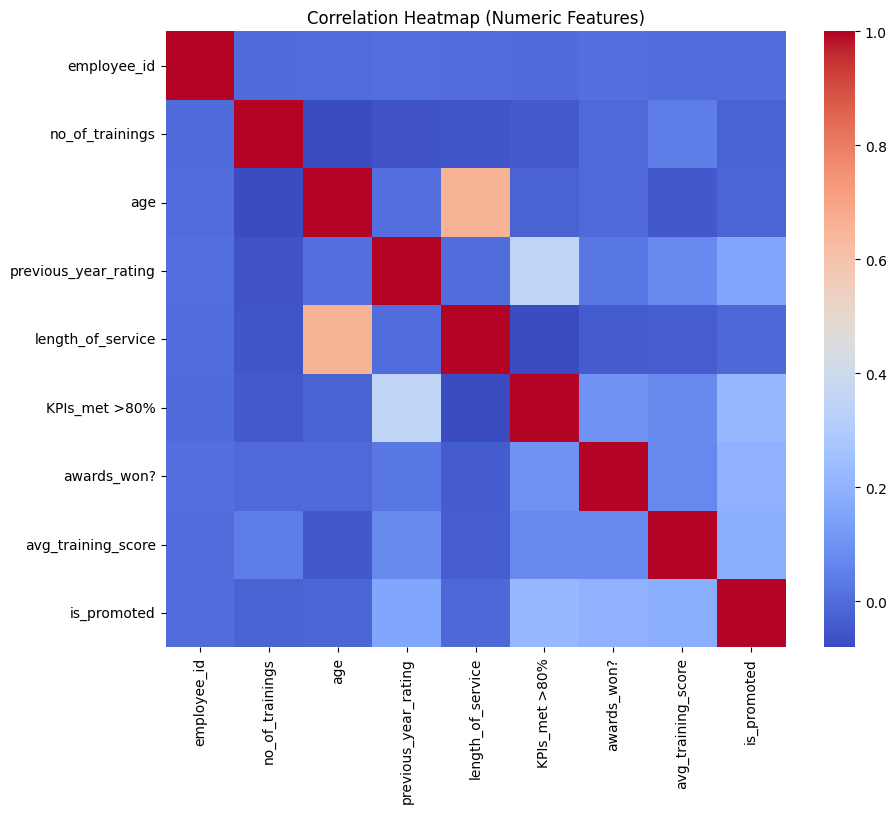


Missing values:
 employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64


In [2]:

plt.figure(figsize=(5,4))
sns.countplot(x='is_promoted', data=train)
plt.title("Target Distribution")
plt.show()


print(train.describe())


plt.figure(figsize=(10,8))
sns.heatmap(train.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


print("\nMissing values:\n", train.isnull().sum())


In [3]:

target = 'is_promoted'
y = train[target]
train = train.drop(columns=[target])


for col in train.columns:
    if train[col].dtype == 'object':
        mode_val = train[col].mode()[0]
        train[col].fillna(mode_val, inplace=True)
        test[col].fillna(mode_val, inplace=True)
    else:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        test[col].fillna(median_val, inplace=True)


num_cols = train.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    train[col] = np.clip(train[col], lower, upper)
    test[col] = np.clip(test[col], lower, upper)


cat_cols = train.select_dtypes(exclude=np.number).columns.tolist()
le = LabelEncoder()

for col in cat_cols:
    if train[col].nunique() <= 10:
        le.fit(list(train[col].values) + list(test[col].values))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
    else:
        combined = pd.concat([train[col], test[col]], axis=0)
        encoded = pd.get_dummies(combined, prefix=col)
        train_enc = encoded.iloc[:len(train), :].reset_index(drop=True)
        test_enc = encoded.iloc[len(train):, :].reset_index(drop=True)
        train = pd.concat([train.drop(columns=[col]).reset_index(drop=True), train_enc], axis=1)
        test = pd.concat([test.drop(columns=[col]).reset_index(drop=True), test_enc], axis=1)


test = test.reindex(columns=train.columns, fill_value=0)


scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])


train[target] = y

print("Final train shape:", train.shape)
print("Final test shape:", test.shape)


/tmp/ipython-input-3192498035.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median_val, inplace=True)
/tmp/ipython-input-3192498035.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Final train shape: (54808, 47)
Final test shape: (23490, 46)


In [4]:

X = train.drop(columns=['is_promoted'])
y = train['is_promoted']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())


Before SMOTE: is_promoted
0    40112
1     3734
Name: count, dtype: int64
After SMOTE: is_promoted
0    40112
1    40112
Name: count, dtype: int64


In [5]:


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        eval_metric='logloss', random_state=42, use_label_encoder=False, n_estimators=200
    )
}

f1_results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds)
    f1_results[name] = f1
    print(f"{name} F1 Score: {f1:.4f}")

best_model_name = max(f1_results, key=f1_results.get)
print("\nBest model so far:", best_model_name, "with F1 =", f1_results[best_model_name])



Training Logistic Regression ...
Logistic Regression F1 Score: 0.2941

Training KNN ...
KNN F1 Score: 0.3163

Training Random Forest ...
Random Forest F1 Score: 0.3904

Training XGBoost ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 Score: 0.4961

Best model so far: XGBoost with F1 = 0.49607982893799


In [6]:

from sklearn.model_selection import GridSearchCV


param_grid = {}


if best_model_name == "XGBoost":
    param_grid = {
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    }
    model = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)


if param_grid:
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_
    print("Best params:", grid.best_params_)
else:
    best_model = model.fit(X_train_bal, y_train_bal)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:47:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [7]:



# Predict on test
test_pred = best_model.predict(test)

# Create submission
submission['is_promoted'] = test_pred
submission.to_csv("/content/final_submission.csv", index=False)
print("✅ Final predictions saved to /content/fin_submission.csv")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:49:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final predictions saved to /content/fin_submission.csv
